# Importing Libraries

In [ ]:
import os
import copy
import time
import random
import pickle

import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm import tqdm

from sklearn.metrics import f1_score, confusion_matrix
from numpy.random import shuffle
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.autograd.profiler as tprofiler
import torch.utils.data as td

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
import time
from torchsummary import summary
import seaborn as sns


from typing import Type, Any, Callable, Union, List, Optional, cast
from collections import OrderedDict 

plt.rcParams["savefig.bbox"] = 'tight'

# Loading Data part

In [ ]:
seed = 42

random.seed(seed)

# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class MultiLabelDataset(Dataset):
    def __init__(self, root, dataframe, transform = None):
        self.dataframe = dataframe
        self.root = root
        self.transform = transform
        self.file_names = dataframe.index
        self.labels = dataframe.values.tolist()
        self.classes = list(dataframe.columns)
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        image = Image.open(os.path.join(self.root, self.file_names[index]))
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float)

In [ ]:
batch_size = 8
norm_arr=([0.4955, 0.4955, 0.4955], [0.2892, 0.2892, 0.2892])
num_workers = 12  #####################################################

import os
import pandas as pd
import torchvision.transforms as T
from torchvision import datasets
import torch.utils.data as td


def load_data(path, batch_size, input_size, norm_arr, 
              num_workers=0):
    
    transform_dict = {"test_val": 
                          T.Compose([
                            #T.ToPILImage(),
                            T.Resize(size=input_size),
                            T.ToTensor(),
                            T.Normalize(*norm_arr)])
                        }
    
    # train = pd.read_csv(os.path.join(path, "train.csv")).drop(['FilePath', 'Patient ID'], axis=1).set_index('Image Index')
    test = pd.read_csv(os.path.join(path, "test.csv")).drop(['FilePath', 'Patient ID'], axis=1).set_index('Image Index')
    # val = pd.read_csv(os.path.join(path, "val.csv")).drop(['FilePath', 'Patient ID'], axis=1).set_index('Image Index')

    test_dataset = MultiLabelDataset(root=os.path.join(path, "test"),
                                        dataframe=test,
                                        transform=transform_dict["test_val"])
    print(test_dataset.classes)
    
    data_loader_test = td.DataLoader(test_dataset,
                                     batch_size=batch_size,
                                     shuffle=False,
                                     drop_last=False,
                                     num_workers=num_workers,
                                     pin_memory=True)

    return {  'test':  data_loader_test}

In [ ]:
images_dir = "drive/MyDrive/xray8_data"

In [ ]:
data_loaders = load_data(images_dir,
                         batch_size = batch_size, 
                         input_size = (256, 256), ############################ check the input size 
                         norm_arr = norm_arr,
                         num_workers=num_workers)

['Effusion', 'No Finding', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Consolidation']


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class_names = ['Effusion', 'No Finding', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Consolidation']

# Loading Saved Model

In [ ]:
# from utils file

from torchvision import models
import torch.nn as nn

def set_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=None):
    '''
    Initialize models for training.
    '''
    model_ft = None
    input_size = 0

    if model_name == "resnet50":
        """ 
            Returns a Resnet 50 model.
        """
        model_ft = models.resnet50(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 232
        
    elif model_name == "resnet34":
        """ 
            Returns a Resnet 34 model.
        """
        model_ft = models.resnet34(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 256

    elif model_name == "inceptionv3":
        """ 
            Returns an Inception v3 model.
        """
        model_ft = models.inception_v3(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        # Auxilary network.
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Primary network.
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299
        
    elif model_name == "vgg16":
        """ 
            Returns a VGG 16 model with batch normalization.
        """
        model_ft = models.vgg16_bn(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 256

    elif model_name == "mobile_net_v3_large":
        """ 
            returns a mobile net V3 large model.
        """
        model_ft = models.mobilenet_v3_large(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[3].in_features
        model_ft.classifier[3] = nn.Linear(num_ftrs, num_classes, bias=True)
        input_size = 232

    elif model_name == "efficient_net_b1":
        """ 
            Returns an efficient net b1 model.
        """
        model_ft = models.efficientnet_b1(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes, bias=True)
        input_size = 255

    elif model_name == "efficient_net_b0":
        """ 
            Returns an efficient net b0 model.
        """
        model_ft = models.efficientnet_b0(weights=use_pretrained)
        set_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes, bias=True)
        input_size = 256

    else:
        print("Unavailable model selected.")

    return model_ft, input_size

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Models options: resnet50, resnet34, inceptionv3, vgg16, mobile_net_v3_large, efficient_net_b1, efficient_net_b0.
model_name = "resnet34"

# Number of classes.
num_classes = 7

# Batch Size.
batch_size = 32

# Epochs to train for.
num_epochs = 100

# Number of workers for data loader.
num_workers = 12

# Imagenet norm array passed as default value.
# norm_arr=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Chest x-ray8 training dataset metrics 
norm_arr=([0.4955, 0.4955, 0.4955], [0.2892, 0.2892, 0.2892])


# Feature extract flag: False - Tune the whole model,
#                       True - Update only the reshaped layer parameters.
feature_extract = False

# Use pretrained flag: None - Use random weights
#                      String - Use pretrained weights given by String
use_pretrained = None

# Initialize the model for this run.
resnet, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained)

cpu


In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
children_counter = 0
for n,c in resnet.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1

Children Counter:  0  Layer Name:  conv1
Children Counter:  1  Layer Name:  bn1
Children Counter:  2  Layer Name:  relu
Children Counter:  3  Layer Name:  maxpool
Children Counter:  4  Layer Name:  layer1
Children Counter:  5  Layer Name:  layer2
Children Counter:  6  Layer Name:  layer3
Children Counter:  7  Layer Name:  layer4
Children Counter:  8  Layer Name:  avgpool
Children Counter:  9  Layer Name:  fc


In [ ]:
class NewModelResnet(nn.Module):
    def __init__(self, resnet, output_layers=None,*args, ):
        super().__init__(*args)
        self.output_layers = [7,8]
        #print(self.output_layers)
        self.selected_out = OrderedDict()

        #PRETRAINED MODEL
        self.pretrained = resnet
        self.fhooks = []

        for i,l in enumerate(list(self.pretrained._modules.keys())):
            if i in self.output_layers:
                self.fhooks.append(getattr(self.pretrained,l).register_forward_hook(self.forward_hook(l)))
    
    def forward_hook(self,layer_name):
        def hook(module, input, output):
            self.selected_out[layer_name] = output
        return hook

    def forward(self, x):
        out = self.pretrained(x)
        return out, self.selected_out

In [ ]:
resnet.load_state_dict(torch.load('drive/MyDrive/xray8/resnet34_chest_xray_8_100_32_0.01_0.001_model_weights.pth', map_location=device)) 

<All keys matched successfully>

In [ ]:
resnetmodel = NewModelResnet(resnet)
resnetmodel = resnetmodel.to(device)

#T-SNE for Resnet

In [ ]:
f = 125
labels = []
outputs = []
with torch.no_grad():
  for b, (image, label) in enumerate(data_loaders['test']):
        if(b%100==0):
          print(b)
        # Apply the model
        image, label = image.to(device), label.to(device)
        _, dictionary = resnetmodel(image)
        labels += label
        outputs += dictionary['layer4']


0
100
200
300
400
500


In [ ]:
len(outputs)

4318

In [ ]:
for i in range(len(outputs)):
  outputs[i] = outputs[i].detach().cpu().data.numpy()
  labels

In [ ]:
outputs = np.asarray(outputs, dtype=np.float64)

In [ ]:
layer4 = torch.tensor(outputs)

In [ ]:
layer4 = layer4.reshape(len(outputs), 512*8*8)
layer4 = layer4.detach().cpu().numpy()

In [ ]:
layer4.shape

(4318, 32768)

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', n_iter=100000).fit_transform(layer4)

In [ ]:
path = '/content/drive/MyDrive/xray8/eval_metrics_resnet34_chest_xray_8_100_32_0.01_0.001_'
pickle_in = open(path + '.pickle',"rb")
val = pickle.load(pickle_in)


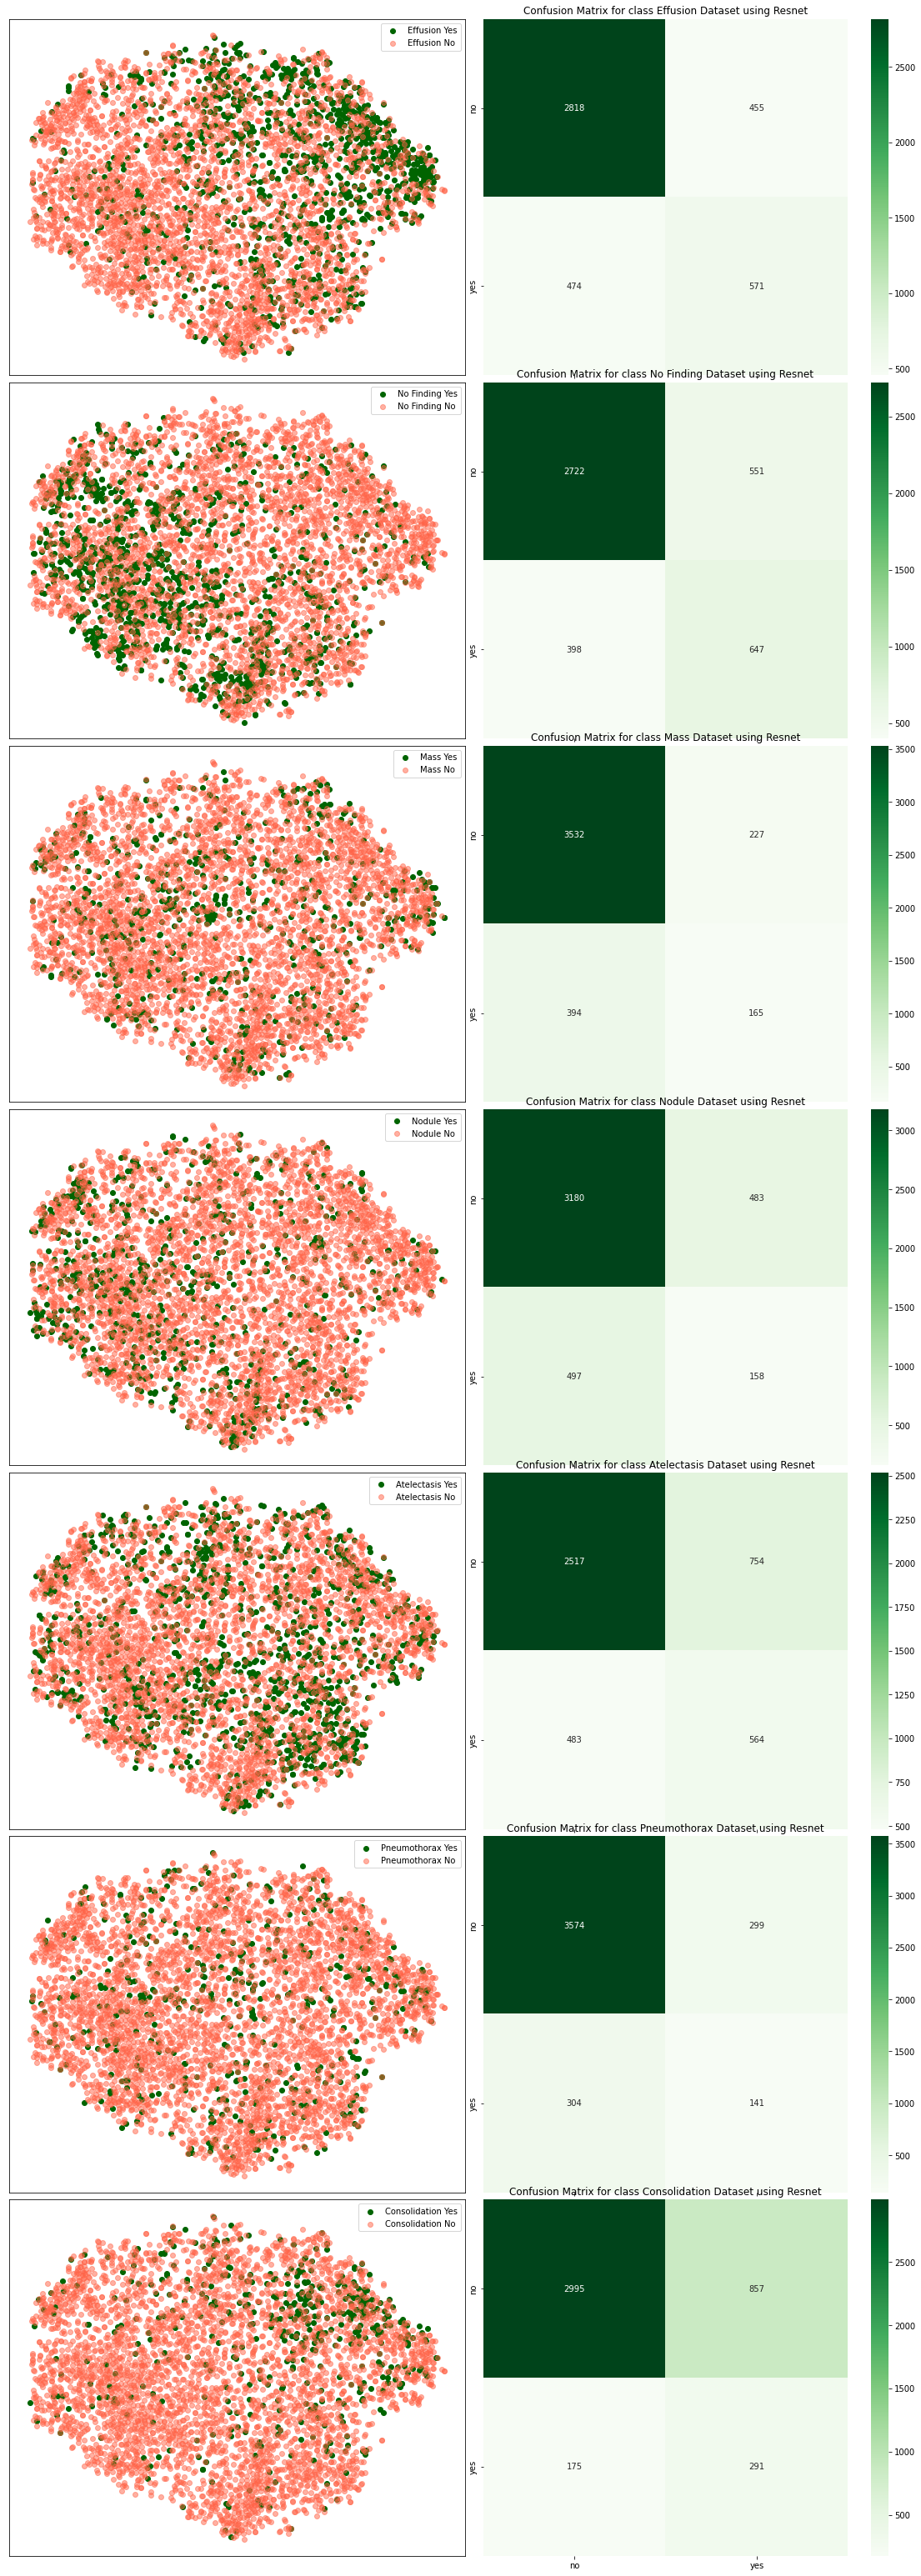

In [ ]:
fig, ax = plt.subplots(7,2, figsize=(20,56))

for i in range(7):
  class_yes = []
  class_no = []

  for j in range(len(X_embedded)):
    # print(labels[i].tolist()
    if(labels[j][i]==0):
      class_no.append(X_embedded[j])
    else:
      class_yes.append(X_embedded[j])

  class_yes = np.array(class_yes)
  class_no = np.array(class_no)

  if(len(class_yes)!=0):
    ax[i][0].scatter(class_yes[:,0], class_yes[:,1], c="darkgreen", label= class_names[i]+" Yes")  
  if(len(class_no)!=0): 
    ax[i][0].scatter(class_no[:,0], class_no[:,1], c="tomato", label=class_names[i]+" No", alpha=0.5)


  ax[i][0].legend()
  ax[i][0].set_xticks([]) 
  ax[i][0].set_yticks([])   
  # ax1.show()


  df_cm = val['cm'][i]
  vmin = np.min(df_cm)
  vmax = np.max(df_cm)
  output_class = ['no', 'yes']


  sns.heatmap(df_cm, annot=True, fmt="g",vmin=vmin, vmax=vmax,cmap = 'Greens', xticklabels=output_class, yticklabels=output_class,  ax=ax[i][1])
  #sns.heatmap(df_cm, annot=True, fmt="g", mask=off_diag_mask, cmap='gray_r',vmin=vmin, vmax=vmax,xticklabels=labels, yticklabels=labels)
  ax[i][1].set_title('Confusion Matrix for class ' + class_names[i]+ ' Dataset using Resnet')
plt.subplots_adjust(wspace=0.04, hspace=0.02)

# MobileNet

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Models options: resnet50, resnet34, inceptionv3, vgg16, mobile_net_v3_large, efficient_net_b1, efficient_net_b0.
model_name = "mobile_net_v3_large"

# Number of classes.
num_classes = 7

# Batch Size.
batch_size = 32

# Epochs to train for.
num_epochs = 100

# Number of workers for data loader.
num_workers = 12

# Imagenet norm array passed as default value.
# norm_arr=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Chest x-ray8 multilabel training dataset metrics 
norm_arr=([0.4955, 0.4955, 0.4955], [0.2892, 0.2892, 0.2892])


# Feature extract flag: False - Tune the whole model,
#                       True - Update only the reshaped layer parameters.
feature_extract = False

# Use pretrained flag: None - Use random weights
#                      String - Use pretrained weights given by String
use_pretrained = None

# Initialize the model for this run.
mobilenet, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained)

cuda:0


In [ ]:
mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
children_counter = 0
for n,c in mobilenet.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n)
    children_counter+=1

Children Counter:  0  Layer Name:  features
Children Counter:  1  Layer Name:  avgpool
Children Counter:  2  Layer Name:  classifier


In [ ]:
class NewModelMobileNet(nn.Module):
    def __init__(self, mobilenet, output_layers=None,*args, ):
        super().__init__(*args)
        self.output_layers = [16]
        #print(self.output_layers)
        self.selected_out = OrderedDict()

        #PRETRAINED MODEL
        self.pretrained = mobilenet
        self.fhooks = []

        for i,l in enumerate(list(self.pretrained._modules['features']._modules.keys())):
            print(i,l)
            if i in self.output_layers:
                self.fhooks.append(getattr(self.pretrained._modules['features'],l).register_forward_hook(self.forward_hook(l)))
    
    def forward_hook(self,layer_name):
        def hook(module, input, output):
            self.selected_out[layer_name] = output
        return hook

    def forward(self, x):
        out = self.pretrained(x)
        return out, self.selected_out

In [ ]:
mobilenet.load_state_dict(torch.load('drive/MyDrive/xray8/mobile_net_v3_large_chest_xray_8_100_32_0.01_0.001_model_weights.pth', map_location=device)) 

<All keys matched successfully>

In [ ]:
mobilenetmodel = NewModelMobileNet(mobilenet)
mobilenetmodel = mobilenetmodel.to(device)

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16


In [ ]:
f = 125
labels = []
outputs = []

with torch.no_grad():
  for b, (image, label) in enumerate(data_loaders['test']):
              if(b%25==0):
                print(b,f)
              # Apply the model
              image, label = image.to(device), label.to(device)
              _, dictionary = mobilenetmodel(image)
              labels += label
              outputs += dictionary['16']
              f-=1

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0 125
25 100
50 75
75 50
100 25
125 0
150 -25
175 -50
200 -75
225 -100
250 -125
275 -150
300 -175
325 -200
350 -225
375 -250
400 -275
425 -300
450 -325
475 -350
500 -375
525 -400


In [ ]:
len(labels)

4318

In [ ]:
for i in range(len(outputs)):
  outputs[i] = outputs[i].detach().cpu().data.numpy()

In [ ]:
outputs = np.asarray(outputs, dtype=np.float64)

In [ ]:
layer16 = torch.tensor(outputs)

In [ ]:
layer16 = layer16.reshape(len(outputs), 960*8*8)
layer16 = layer16.detach().cpu().numpy()

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', n_iter=100000).fit_transform(layer16)

In [ ]:
path = '/content/drive/MyDrive/xray8/eval_metrics_mobile_net_v3_large_chest_xray_8_100_32_0.01_0.001_'
pickle_in = open(path + '.pickle',"rb")
val = pickle.load(pickle_in)

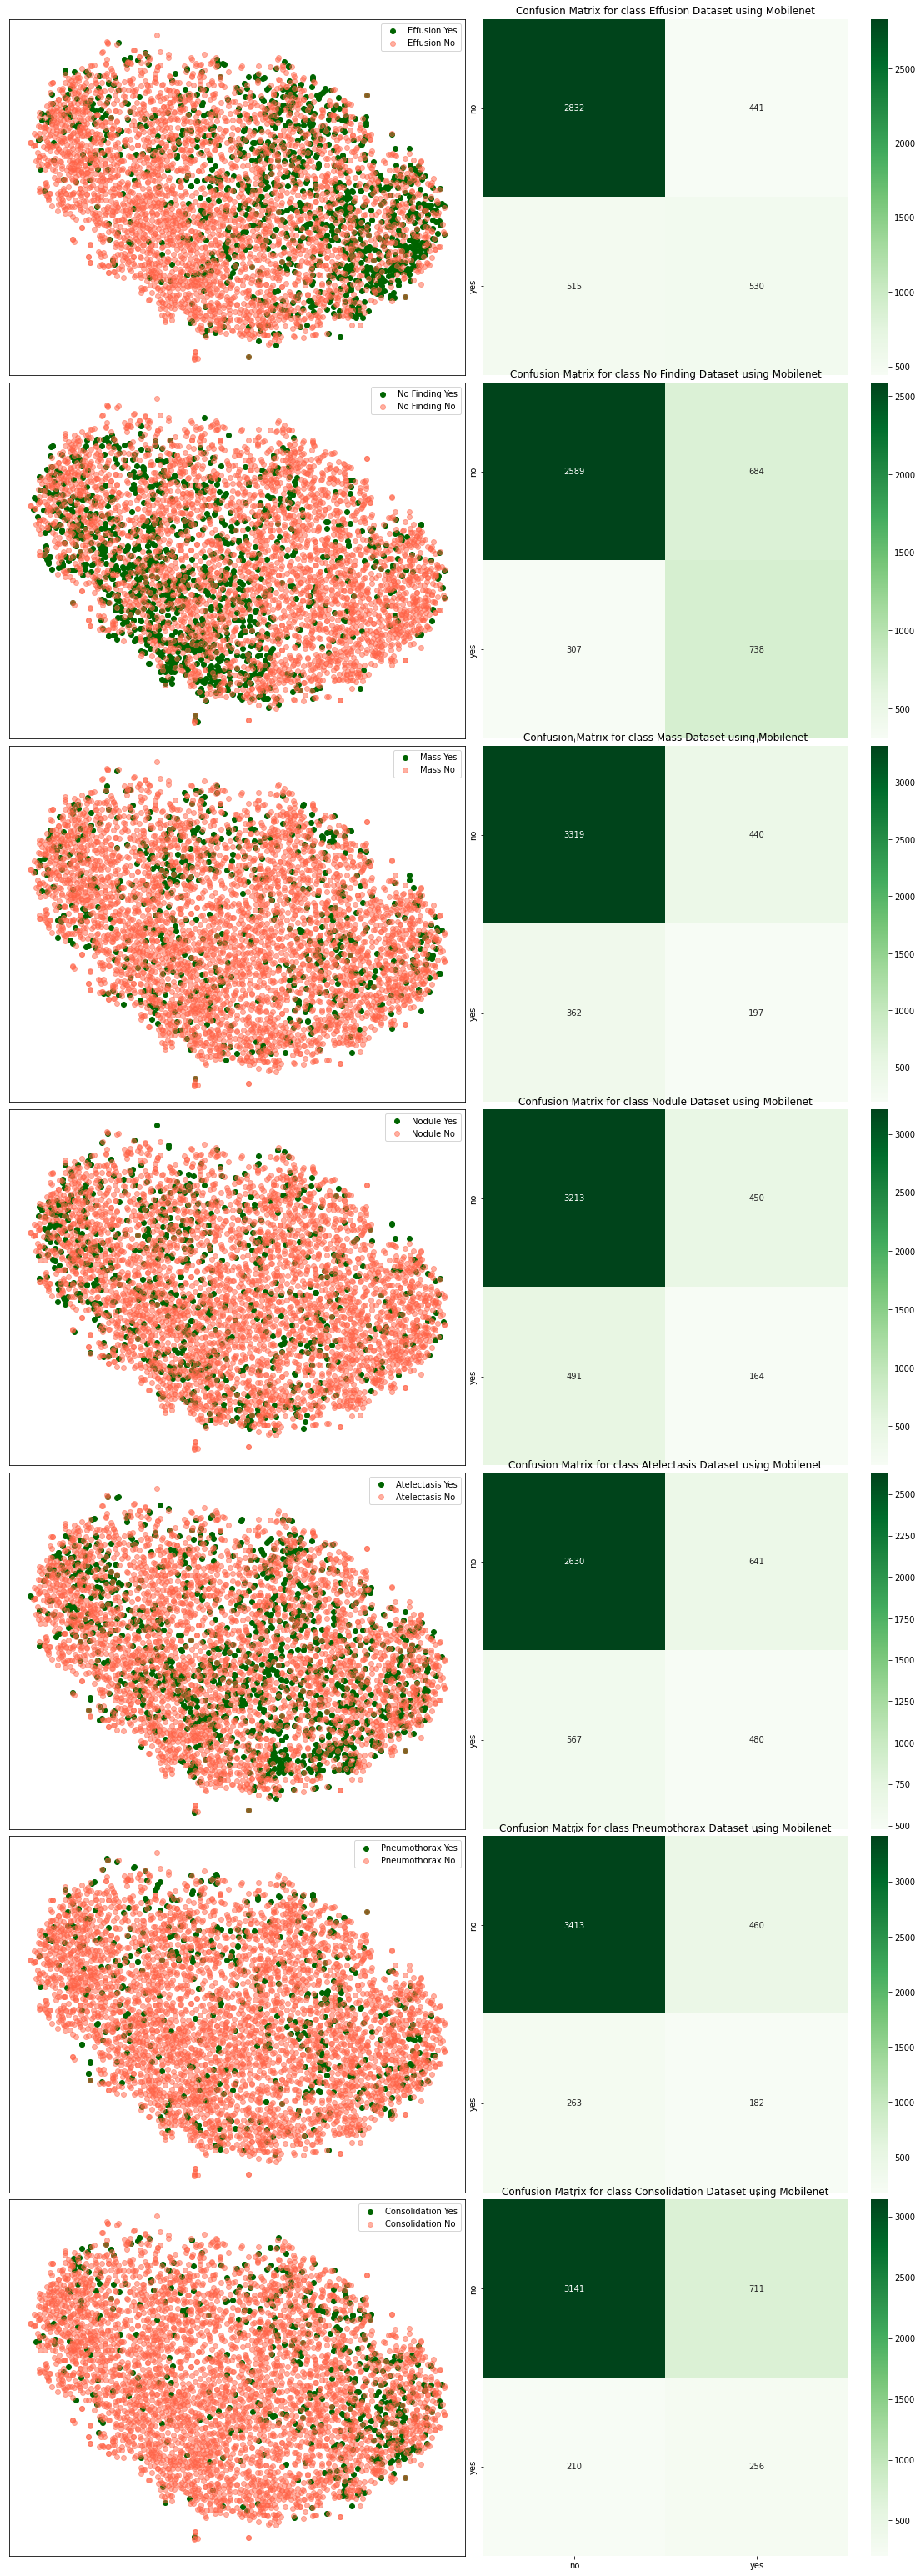

In [ ]:
fig, ax = plt.subplots(7,2, figsize=(20,56))

for i in range(7):
  class_yes = []
  class_no = []

  for j in range(len(X_embedded)):
    # print(labels[i].tolist()
    if(labels[j][i]==0):
      class_no.append(X_embedded[j])
    else:
      class_yes.append(X_embedded[j])

  class_yes = np.array(class_yes)
  class_no = np.array(class_no)

  if(len(class_yes)!=0):
    ax[i][0].scatter(class_yes[:,0], class_yes[:,1], c="darkgreen", label= class_names[i]+" Yes")  
  if(len(class_no)!=0): 
    ax[i][0].scatter(class_no[:,0], class_no[:,1], c="tomato", label=class_names[i]+" No", alpha=0.5)


  ax[i][0].legend()
  ax[i][0].set_xticks([]) 
  ax[i][0].set_yticks([])   
  # ax1.show()


  df_cm = val['cm'][i]
  vmin = np.min(df_cm)
  vmax = np.max(df_cm)
  output_class = ['no', 'yes']


  sns.heatmap(df_cm, annot=True, fmt="g",vmin=vmin, vmax=vmax,cmap = 'Greens', xticklabels=output_class, yticklabels=output_class,  ax=ax[i][1])
  #sns.heatmap(df_cm, annot=True, fmt="g", mask=off_diag_mask, cmap='gray_r',vmin=vmin, vmax=vmax,xticklabels=labels, yticklabels=labels)
  ax[i][1].set_title('Confusion Matrix for class ' + class_names[i]+ ' Dataset using Mobilenet')
plt.subplots_adjust(wspace=0.04, hspace=0.02)

# Efficient - Net

In [ ]:
# Models options: resnet50, resnet34, inceptionv3, vgg16, mobile_net_v3_large, efficient_net_b1, efficient_net_b0.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_name = "efficient_net_b1"

# Number of classes.
num_classes = 7

# Number of workers for data loader.
num_workers = 0

# Pneumonia dataset metrics
norm_arr=([0.4810, 0.4810, 0.4810], [0.2373, 0.2373, 0.2373])

# Feature extract flag: False - Tune the whole model,
#                       True - Update only the reshaped layer parameters.
feature_extract = False

# Use pretrained flag: None - Use random weights
#                      String - Use pretrained weights given by String
use_pretrained = None
# Initialize the model for this run.
efficientnet, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained)

In [ ]:
children_counter = 0
for n,c in efficientnet.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n)
    children_counter+=1

Children Counter:  0  Layer Name:  features
Children Counter:  1  Layer Name:  avgpool
Children Counter:  2  Layer Name:  classifier


In [ ]:
class NewModelEfficientNet(nn.Module):
    def __init__(self, efficientnet, output_layers=None,*args, ):
        super().__init__(*args)
        self.output_layers = [8]
        #print(self.output_layers)
        self.selected_out = OrderedDict()

        #PRETRAINED MODEL
        self.pretrained = efficientnet
        self.fhooks = []

        for i,l in enumerate(list(self.pretrained._modules['features']._modules.keys())):
            if i in self.output_layers:
                # print(getattr(self.pretrained._modules['features'],l))
                self.fhooks.append(getattr(self.pretrained._modules['features'],l).register_forward_hook(self.forward_hook(l)))
    
    def forward_hook(self,layer_name):
        def hook(module, input, output):
            self.selected_out[layer_name] = output.cpu()
        return hook

    def forward(self, x):
        out = self.pretrained(x)
        return out, self.selected_out

In [ ]:
efficientnet.load_state_dict(torch.load('drive/MyDrive/xray8/efficient_net_b1_chest_xray_8_100_32_0.01_0.001_model_weights.pth', map_location=device)) 

<All keys matched successfully>

In [ ]:
efficientnetmodel = NewModelEfficientNet(efficientnet)
efficientnetmodel.to(device)

NewModelEfficientNet(
  (pretrained): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
          

In [ ]:
f = 125
labels = []
outputs = []

with torch.no_grad():
  for b, (image, label) in enumerate(data_loaders['test']):
      if(b%100==0):
        print(b)

      # Apply the model
      image, label = image.to(device), label.to(device)
      _, dictionary = efficientnetmodel(image)
      labels += label
      dictionary['8'] = dictionary['8'].cpu()
      outputs += dictionary['8']

      del image, label, dictionary
      torch.cuda.empty_cache()
              

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0
100
200
300
400
500


In [ ]:
len(outputs), outputs[0].shape

(4318, torch.Size([1280, 8, 8]))

In [ ]:
for i in range(len(outputs)):
  outputs[i] = outputs[i].numpy()

In [ ]:
outputs = np.asarray(outputs, dtype=np.float64)

In [ ]:
layer8 = torch.tensor(outputs)

In [ ]:
layer8 = layer8.reshape(len(outputs), 1280*8*8)
layer8 = layer8.detach().cpu().numpy()

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', n_iter=100000).fit_transform(layer8)

In [ ]:
path = '/content/drive/MyDrive/xray8/eval_metrics_mobile_net_v3_large_chest_xray_8_100_32_0.01_0.001_'
pickle_in = open(path + '.pickle',"rb")
val = pickle.load(pickle_in)

In [ ]:
val['cm']

array([[[2832,  441],
        [ 515,  530]],

       [[2589,  684],
        [ 307,  738]],

       [[3319,  440],
        [ 362,  197]],

       [[3213,  450],
        [ 491,  164]],

       [[2630,  641],
        [ 567,  480]],

       [[3413,  460],
        [ 263,  182]],

       [[3141,  711],
        [ 210,  256]]])

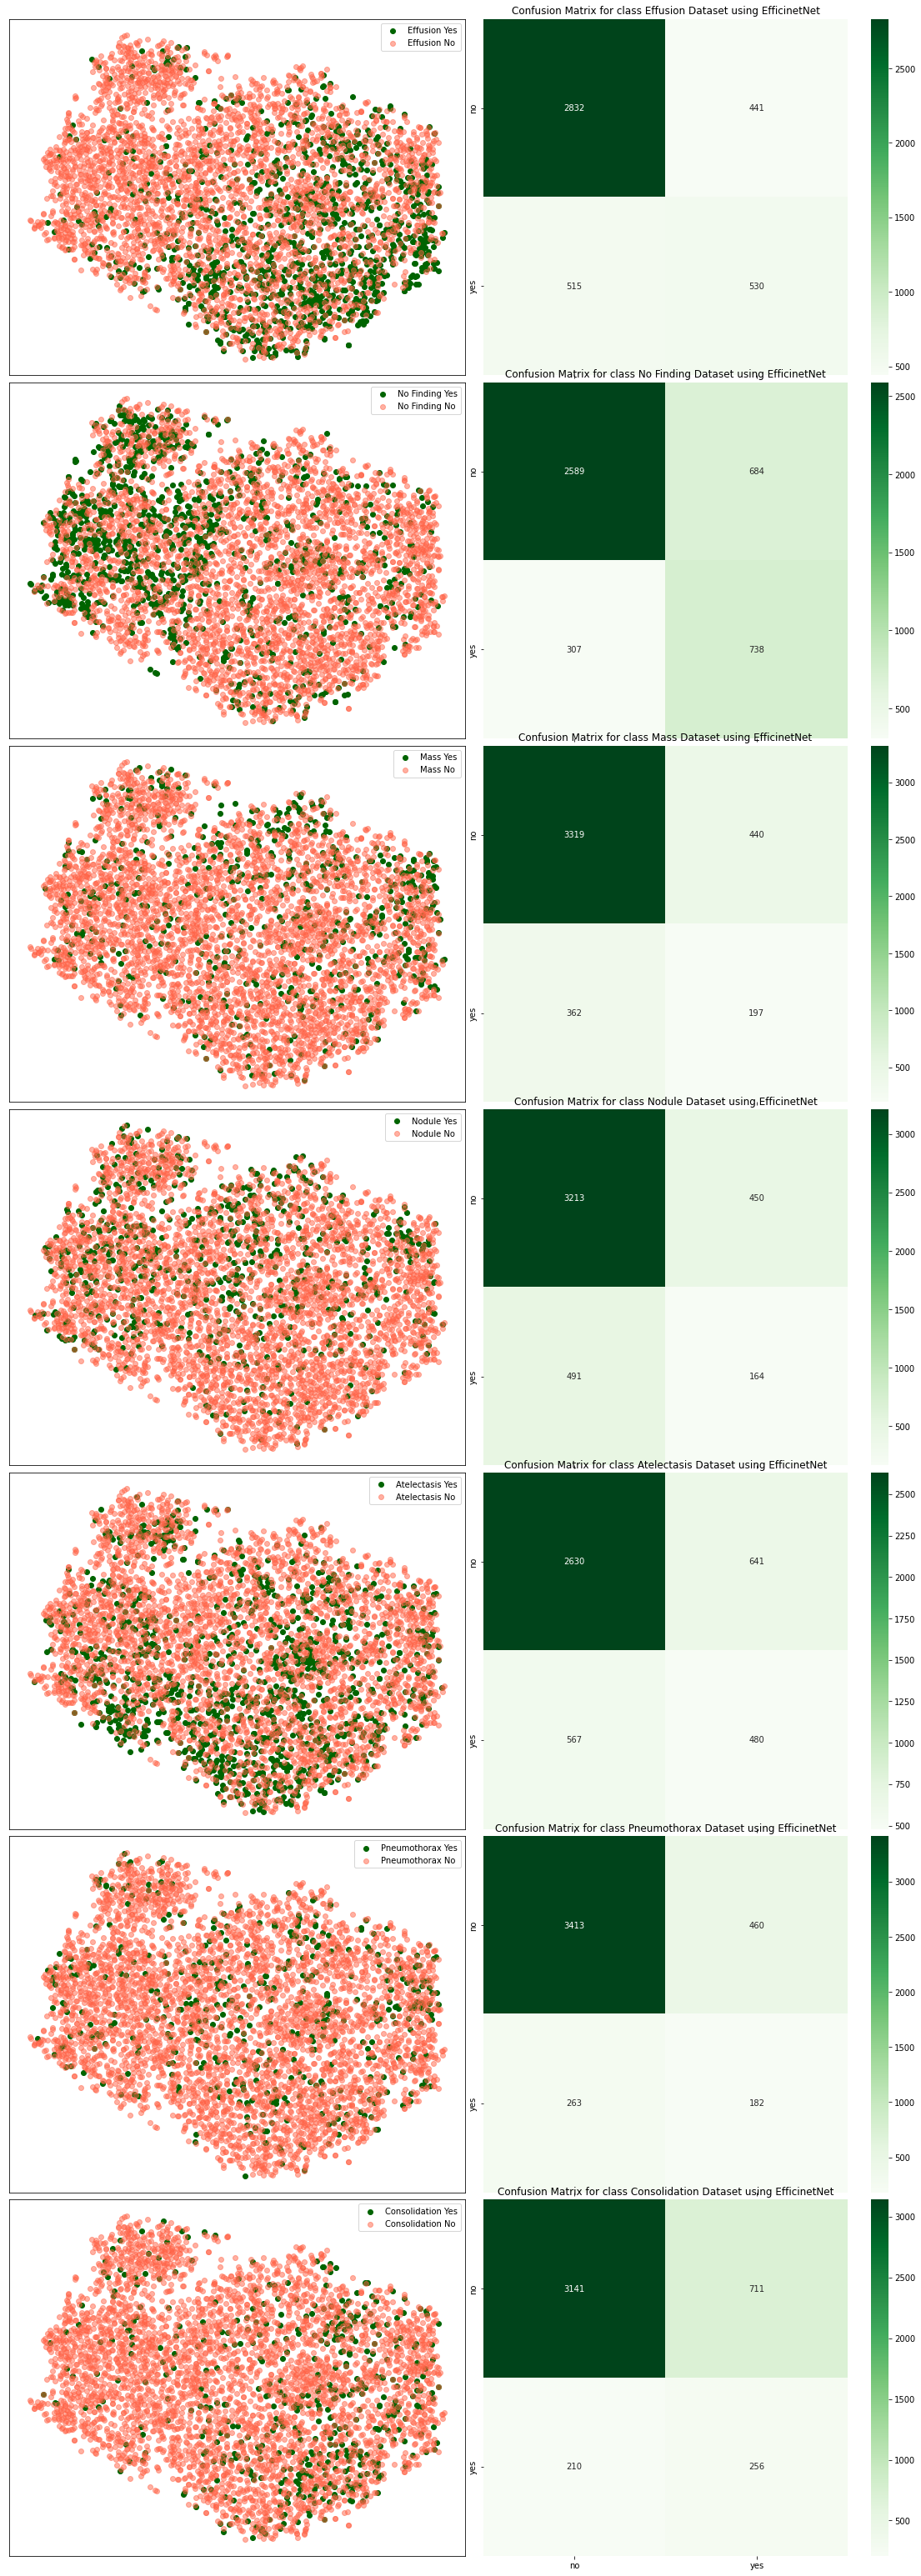

In [ ]:
fig, ax = plt.subplots(7,2, figsize=(20,56))

for i in range(7):
  class_yes = []
  class_no = []

  for j in range(len(X_embedded)):
    # print(labels[i].tolist()
    if(labels[j][i]==0):
      class_no.append(X_embedded[j])
    else:
      class_yes.append(X_embedded[j])

  class_yes = np.array(class_yes)
  class_no = np.array(class_no)

  if(len(class_yes)!=0):
    ax[i][0].scatter(class_yes[:,0], class_yes[:,1], c="darkgreen", label= class_names[i]+" Yes")  
  if(len(class_no)!=0): 
    ax[i][0].scatter(class_no[:,0], class_no[:,1], c="tomato", label=class_names[i]+" No", alpha=0.5)


  ax[i][0].legend()
  ax[i][0].set_xticks([]) 
  ax[i][0].set_yticks([])   
  # ax1.show()


  df_cm = val['cm'][i]
  vmin = np.min(df_cm)
  vmax = np.max(df_cm)
  output_class = ['no', 'yes']


  sns.heatmap(df_cm, annot=True, fmt="g",vmin=vmin, vmax=vmax,cmap = 'Greens', xticklabels=output_class, yticklabels=output_class,  ax=ax[i][1])
  #sns.heatmap(df_cm, annot=True, fmt="g", mask=off_diag_mask, cmap='gray_r',vmin=vmin, vmax=vmax,xticklabels=labels, yticklabels=labels)
  ax[i][1].set_title('Confusion Matrix for class ' + class_names[i]+ ' Dataset using EfficinetNet')
plt.subplots_adjust(wspace=0.04, hspace=0.02)

# EfficientNet Transfer Learning

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_name = "efficient_net_b1"

# Number of classes.
num_classes = 7

# Number of workers for data loader.
num_workers = 0

norm_arr=([0.4810, 0.4810, 0.4810], [0.2373, 0.2373, 0.2373])

# Feature extract flag: False - Tune the whole model,
#                       True - Update only the reshaped layer parameters.
feature_extract = False

# Use pretrained flag: None - Use random weights
#                      String - Use pretrained weights given by String
use_pretrained = True

# Initialize the model for this run.
efficientnet_tl, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-533bc792.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

In [ ]:
data_loaders = load_data(images_dir,
                         batch_size = batch_size, 
                         input_size = (input_size, input_size), ############################
                         norm_arr = norm_arr,
                         num_workers=num_workers)

['Effusion', 'No Finding', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Consolidation']


In [ ]:
efficientnet_tl.load_state_dict(torch.load('drive/MyDrive/xray8/efficient_net_b1_chest_xray_8_tl_100_32_0.01_0.001_model_weights.pth', map_location=device)) 

<All keys matched successfully>

In [ ]:
efficientnetmodeltl = NewModelEfficientNet(efficientnet_tl)
efficientnetmodeltl = efficientnetmodeltl.to(device)

In [ ]:
efficientnet_tl

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
f = 125
labels = []
outputs = []

with torch.no_grad():
  for b, (image, label) in enumerate(data_loaders['test']):
      if(b%100==0):
        print(b)

      # Apply the model
      image, label = image.to(device), label.to(device)
      _, dictionary = efficientnetmodeltl(image)
      labels += label
      dictionary['8'] = dictionary['8'].cpu()
      outputs += dictionary['8']

      del image, label, dictionary
      torch.cuda.empty_cache()
              

0
100
200
300
400
500


In [ ]:
for i in range(len(outputs)):
  outputs[i] = outputs[i].numpy()

In [ ]:
layer8 = torch.tensor(outputs)

<ipython-input-35-e2fe3c25e560>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  layer8 = torch.tensor(outputs)


In [ ]:
layer8 = layer8.reshape(len(outputs), 1280*8*8)
layer8 = layer8.detach().cpu().numpy()

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', n_iter=10000).fit_transform(layer8)

In [ ]:
path = '/content/drive/MyDrive/xray8/eval_metrics_efficient_net_b1_chest_xray_8_tl_100_32_0.01_0.001_'
pickle_in = open(path + '.pickle',"rb")
val = pickle.load(pickle_in)

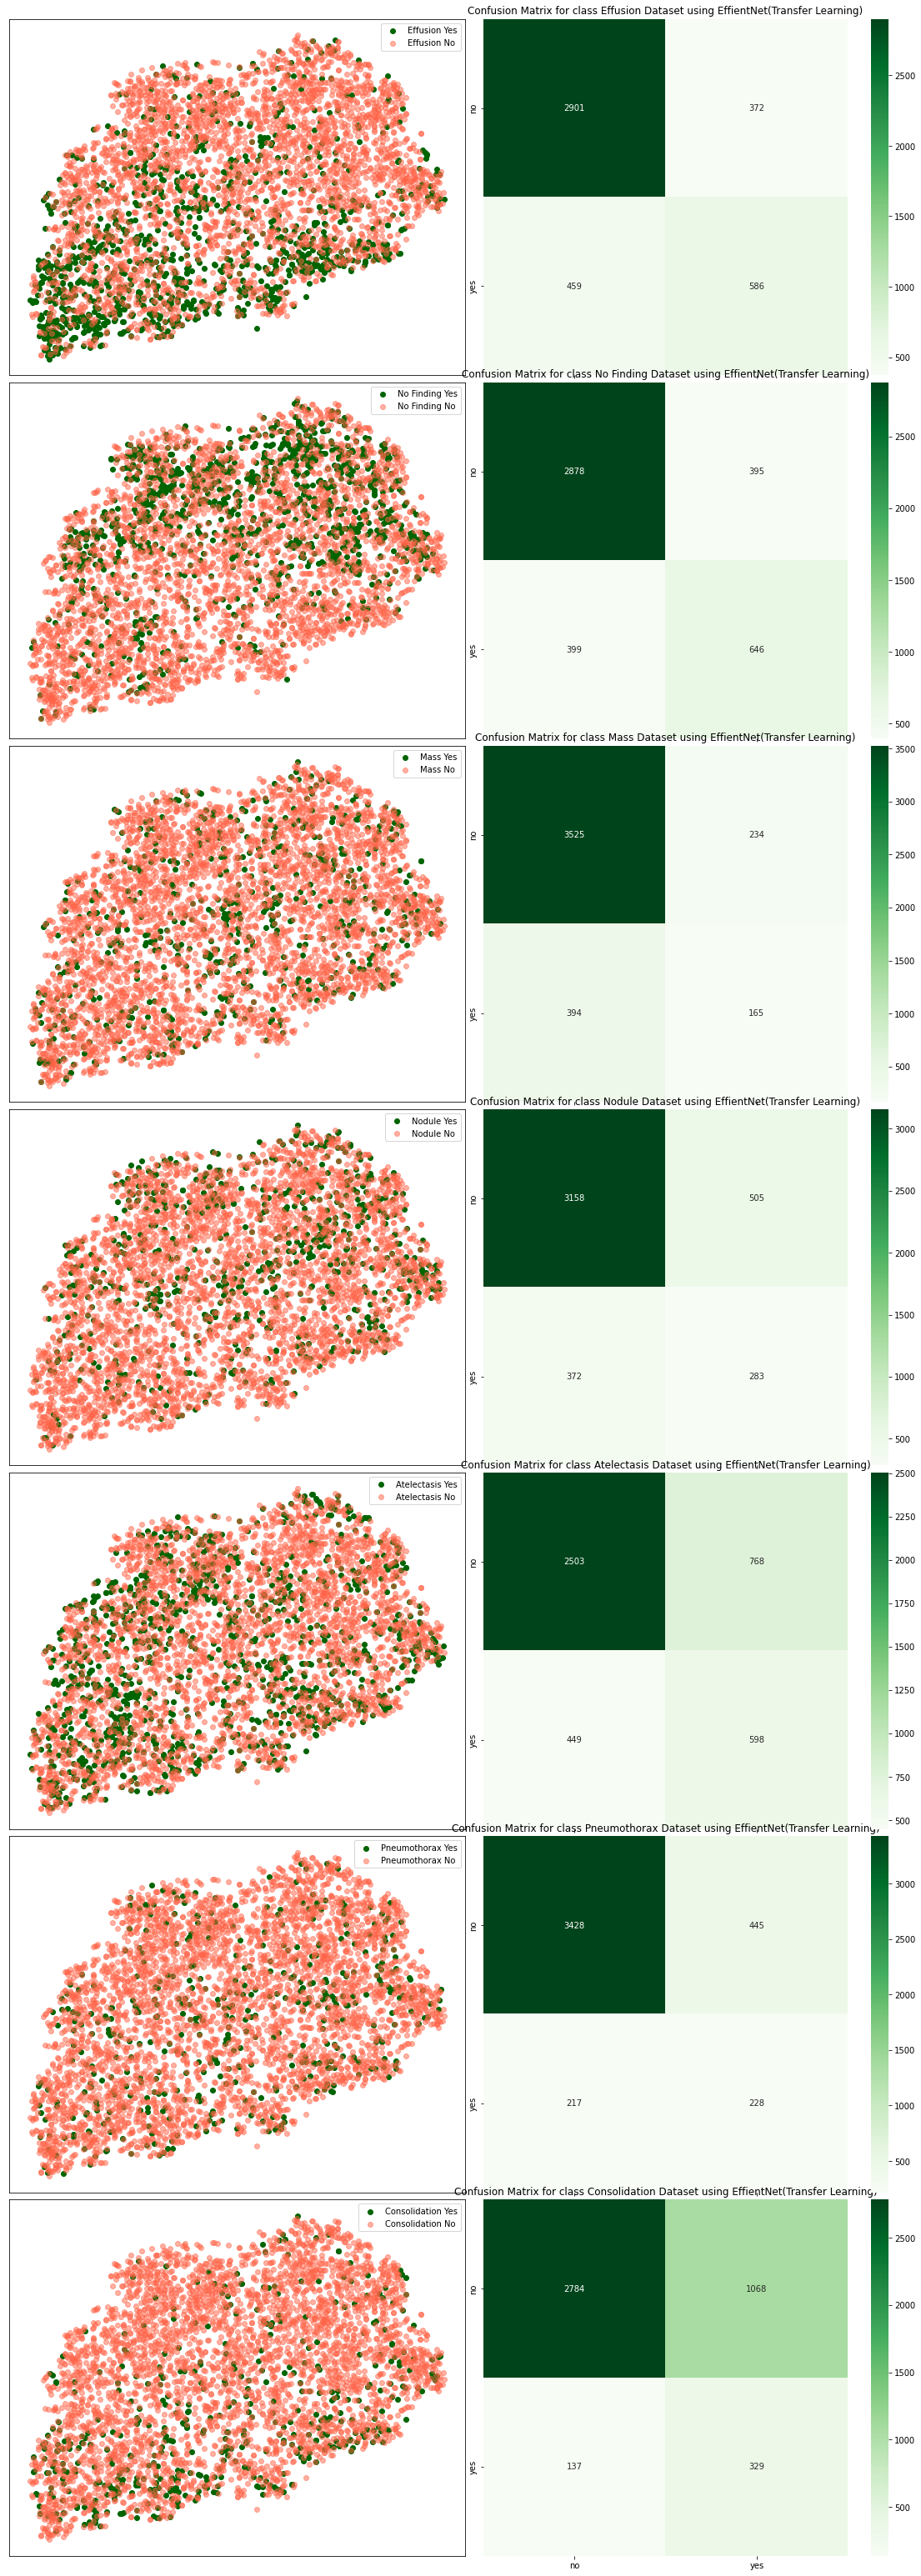

In [ ]:
fig, ax = plt.subplots(7,2, figsize=(20,56))

for i in range(7):
  class_yes = []
  class_no = []

  for j in range(len(X_embedded)):
    # print(labels[i].tolist()
    if(labels[j][i]==0):
      class_no.append(X_embedded[j])
    else:
      class_yes.append(X_embedded[j])

  class_yes = np.array(class_yes)
  class_no = np.array(class_no)

  if(len(class_yes)!=0):
    ax[i][0].scatter(class_yes[:,0], class_yes[:,1], c="darkgreen", label= class_names[i]+" Yes")  
  if(len(class_no)!=0): 
    ax[i][0].scatter(class_no[:,0], class_no[:,1], c="tomato", label=class_names[i]+" No", alpha=0.5)


  ax[i][0].legend()
  ax[i][0].set_xticks([]) 
  ax[i][0].set_yticks([])   
  # ax1.show()


  df_cm = val['cm'][i]
  vmin = np.min(df_cm)
  vmax = np.max(df_cm)
  output_class = ['no', 'yes']


  sns.heatmap(df_cm, annot=True, fmt="g",vmin=vmin, vmax=vmax,cmap = 'Greens', xticklabels=output_class, yticklabels=output_class,  ax=ax[i][1])
  #sns.heatmap(df_cm, annot=True, fmt="g", mask=off_diag_mask, cmap='gray_r',vmin=vmin, vmax=vmax,xticklabels=labels, yticklabels=labels)
  ax[i][1].set_title('Confusion Matrix for class ' + class_names[i]+ ' Dataset using EffientNet(Transfer Learning)')
  plt.subplots_adjust(wspace=0.04, hspace=0.02)